# Imports

In [18]:
from c3po.examples.chalmers_pulses import *

# REQUIRED for c3
import qutip as qt
# FUTURE: import tensorflow as tf 
# REASON: tensorflow will become a hard requirement for c3 as certain 
#         functionality (i.e. GOAT) will depend on it


# import parts of c3 that are needed for the task at hand 
from c3po.main.gate import Gate as gt
from c3po.fidelity.measurement import Experiment as exp_backend


# optional/additional imports 
from math import * # pi 
import numpy as np
import matplotlib.pyplot as plt  # for plotting
import os   # for interacting with operating system, i.e. creating files

# connection to local experimental setup
  
how is the data given by the optimizer transmitted to the local experimental setup?

In [19]:
# EXAMPLE: communication via sockets

def create_socket():

    # PLACEHOLDER

    return 0


def send_data(socket, data):

    # PLACEHOLDER

    return 0


def read_data(socket):

    # PLACEHOLDER

    return 0

# pulse specification in c3


## Example: Cosine Pulse

In [20]:
pulse1 = Cosine(False)
pulse1.amplitude = 0.5
pulse1.width = 10E-9
pulse1.plateau = 0.4e-7
pulse1.frequency = 0.0
pulse1.phase = 0.0
pulse1.use_drag = False
pulse1.drag_coefficient = 0.0
pulse1.drag_detuning = 0.0
pulse1.start_at_zero = False
pulse1.complex = False

# gate.T_final=100e-9

t0 = 50e-9

# chalmers <=>  c3
#    ?     <=> freq

# in calculate_waveform:
#    y     <=> amp * envelope(ts, p_idx, guess) 
# solution1: create pulse object in chalmers code with amplitude = 1 but set amp in pulse specification for c3 to 
#            the right value
# solution2: rewrite in chalmers code 'calculate_envelope' to give y without amp
# solution3: extract/copy 'calculate_envelope' from chalmers code and modify it in c3 file to fit the new needs

#    omega <=> freq_offset
#    phase <=> xy_angle



def cos_envelope(t, idx, guess):
    tau = guess[idx['width']]
    plateau = guess[idx['plateau']]
    t0 = guess[idx['t0']]
    if plateau == 0:
        values = (1.0 / 2.0 *
                  (1 - np.cos(2 * np.pi * (t - t0 + tau / 2) / tau)))
    else:
        values = np.ones_like(t)
        values[t < t0 - plateau / 2] = 1.0 / 2.0 * \
            (1 - np.cos(2 * np.pi *
                        (t[t < t0 - plateau / 2] - t0 +
                         plateau / 2 + tau / 2) / tau))
        values[t > t0 + plateau / 2] = 1.0 / 2.0 * \
            (1 - np.cos(2 * np.pi *
                        (t[t > t0 + plateau / 2] - t0 -
                         plateau / 2 + tau / 2) / tau))
        
    total_duration = tau + plateau # why not 2 * width?
        
    values[t < (t0 - total_duration / 2)] = 0
    values[t > (t0 + total_duration / 2)] = 0        

    return values    
    
    
cosine_pulse = {
    'control1':{
        'carrier1':{
            'freq' : 6e9*2*pi, #taken from above example still needs to be adjusted to chalmers setup
            'pulses':{
                'pulse':{
                    #the token 'pulse' is free to chose i.e. 'pulse1', 'pulseX', 'p1', ...
                    'params': {
                            # required:
                            'amp': pulse1.amplitude, 
                            'xy_angle': pulse1.phase, 
                            'freq_offset': 2*pi*pulse1.frequency, #corresponds to omega in calculate_envelope
                            # optional (params for 'func')
                            'width': pulse1.width,
                            'plateau': pulse1.plateau,
                            't0': t0
                            # self.use_drag = False
                            # self.drag_coefficient = 0.0
                            # self.drag_detuning = 0.0
                            # self.start_at_zero = False
                        },
                    'func': cos_envelope
                    }                    
                }
            }
        }
    }


# everything that appears in bounds will appear in the optimizer (everything that appears here NEEDS to be specified
# first in the pulse dict). if you don't want to optimize something don't put it in bounds
pulse_bounds = {

    # PLACEHOLDER

}

## Example: Gaussian Pulse

In [21]:
pulse2 = Gaussian(False)
pulse2.amplitude = 0.5
pulse2.width = 10E-9
pulse2.plateau = 0.4e-7
pulse2.frequency = 0.0
pulse2.phase = 0.0
pulse2.use_drag = False
pulse2.drag_coefficient = 0.0
pulse2.drag_detuning = 0.0
pulse2.start_at_zero = False
pulse2.complex = False

# gate.T_final=100e-9

t0 = 50e-9

def gauss_envelope(t, idx, guess):
    width = guess[idx['width']]
    plateau = guess[idx['plateau']]
    t0 = guess[idx['t0']]
    start_at_zero = guess[idx['start_at_zero']]
    # width is two t std
    # std = self.width/2;
    # alternate; std is set to give total pulse area same as a square
    std = width / np.sqrt(2 * np.pi)
    values = np.zeros_like(t)
    if plateau == 0:
        # pure gaussian, no plateau
        if std > 0:
            values = np.exp(-(t - t0)**2 / (2 * std**2))
    else:
        # add plateau
        values = np.array(
            ((t >= (t0 - plateau / 2)) & (t <
                                               (t0 + plateau / 2))),
            dtype=float)
        if std > 0:
            # before plateau
            values += ((t < (t0 - plateau / 2)) * np.exp(
                -(t - (t0 - plateau / 2))**2 / (2 * std**2)))
            # after plateau
            values += ((t >= (t0 + plateau / 2)) * np.exp(
                -(t - (t0 + plateau / 2))**2 / (2 * std**2)))

    # TODO  Fix this
    if start_at_zero:
        values = values - values.min()
        values = values / values.max()
    #values = values * self.amplitude

    truncation_range = 5
    total_duration = truncation_range * width + plateau
    
    # Make sure the waveform is zero outside the pulse
    values[t < (t0 - total_duration / 2)] = 0
    values[t > (t0 + total_duration / 2)] = 0
    
    return values


gaussian_pulse = {
    'control1':{
        'carrier1':{
            'freq' : 6e9*2*pi, #taken from above example still needs to be adjusted to chalmers setup
            'pulses':{
                'pulse':{ #the token 'pulse' is free to chose i.e. 'pulse1', 'pulseX', 'p1', ...
                    'params': {
                            # required:
                            'amp': pulse2.amplitude, 
                            'xy_angle': pulse2.phase, 
                            'freq_offset': 2*pi*pulse2.frequency, #corresponds to omega in calculate_envelope
                            # optional (params for 'func'):
                            'width': pulse2.width,
                            'plateau': pulse2.plateau,
                            't0': t0,
                            # self.use_drag = False
                            # self.drag_coefficient = 0.0
                            # self.drag_detuning = 0.0
                            'start_at_zero': pulse2.start_at_zero
                        },
                    'func': gauss_envelope
                    }                    
                }
            }
        }
    }

# creation of gate object

Represents a quantum gate with a fixed parametrization and envelope shape. 


In [22]:
# EXAMPLE: Assume X_gate is target of operation

X_gate = gt('qubit_1', qt.sigmax())
X_gate.set_parameters('initial', cosine_pulse)
#X_gate.set_bounds(pulse_bounds)

# default values in gate
T_final=100e-9
res=1e9

t = np.linspace(0, T_final, int(T_final*res))
iq = X_gate.get_IQ('initial')

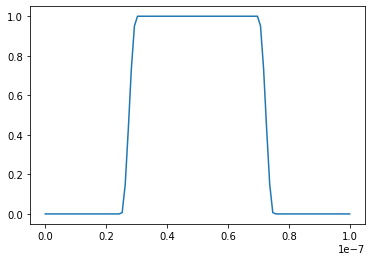

In [23]:
#print(iq['control1']['carrier1']['I'])
plt.plot(t,iq['control1']['carrier1']['I'])
plt.show()

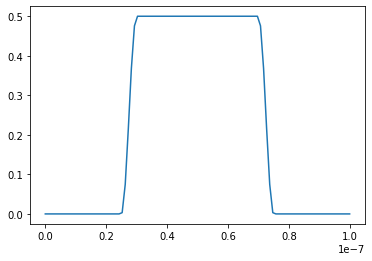

In [24]:
# amplitude scaling seems to be incorrect. factor 0.5 too much?

wf = pulse1.calculate_waveform(t0, t)

plt.plot(t,wf)
plt.show()

In [25]:
# EXAMPLE: Assume X_gate is target of operation

X_gate = gt('qubit_1', qt.sigmax())
X_gate.set_parameters('initial', gaussian_pulse)
#X_gate.set_bounds(pulse_bounds)

# default values in gate
T_final=100e-9
res=1e9

t = np.linspace(0, T_final, int(T_final*res))
iq = X_gate.get_IQ('initial')

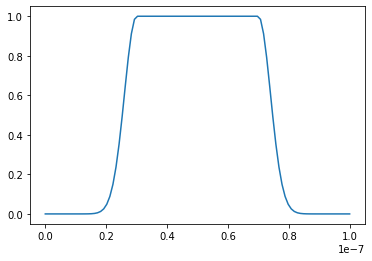

In [26]:
#print(iq['control1']['carrier1']['I'])
plt.plot(t,iq['control1']['carrier1']['I'])
plt.show()

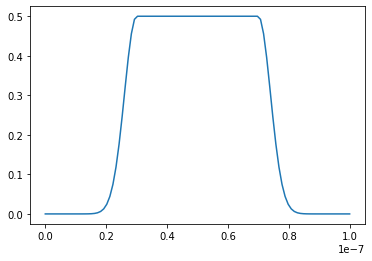

In [27]:
# amplitude scaling seems to be incorrect. factor 0.5 too much?

wf = pulse2.calculate_waveform(t0, t)

plt.plot(t,wf)
plt.show()

# evaluation function

Provide a function, specific to your experimental setup, that takes a several sets of parameters and provides a figure of merit for each.

In [28]:
def evaluate_pulse(gate, samples):

    # PLACEHOLDER
    #   send pulses to experiment and receive output 

    infidelities = 0
    return infidelities

# creation of experiment object 
driver for an experiment

In [29]:
# EXAMPLE:

fridge = exp_backend(evaluate_pulse)

# calibration

In [ ]:
# EXAMPLE:

# create paths for storing results of calibration process
data_path = "/tmp/c3_data/"
optim_name = data_path + "x_gate_calibration"
if not os.path.isdir(data_path):
    os.makedirs(data_path)
if not os.path.isdir(optim_name):
    os.makedirs(optim_name)


# change working path to 
ptim_name+"/"+time.strftime("%d%m%y-%H%M%S", time.localtime())
os.makedirs(pwd)

# input for function calibrate of Experiment obj 

opts = {
    'CMA_stds' : [1, 1, 1, 1, 1],
    'ftarget' : 1e-4,
    'popsize' : 20
}

# start calibration:
# Provide a gate to be calibrated with a gradient free search algorithm.
# At the moment this is CMA-ES and you can give valid opts to the cma-es 
# optimizer

fridge.calibrate(X_gate, opts)

# Q: Incorporate Chalmers calibration?
#       - Nelder-Mead.py
#       - Bayesian-Gaussian-Process.py